# Below is with Generic Likelihood Model Class

In [1]:
import os, csv, random, time
from __future__ import division
from matplotlib import  pyplot as plt
import numpy as np
import scipy.io as sio
from scipy import stats
from collections import deque
import seaborn as sns
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

1. The function $regularized\_vector$ is what Nihar proposed. 

Suppose $w^*$ is the true value and $\hat{w}$ is the inferred value from our optimization, we want to minimize $||w^* - a \cdot \hat{w} - b||_2^2 $ by finding optimial value of a and b, which will be done through $matching\_func$. And then we introduce a new value $v= a\cdot \hat{w} + b$ as the new weight for the videos. 

All the error metric evaluation would be made between $v$ and $w^*$, and here we are using $L_2$ norm, which is assessed through $performance_nihar$

2. The function $performance\_isabelle$ is what Isabelle proposed.

Assume 3 scores $T_1, T_2, T_3$, that are adjacent when we rank all true scores, and the results scores of the corresponding videos $R_1, R_2, R_3$. We can compute $||\frac{T_2-T_1}{T_3-T_1+\epsilon}  - \frac{R_2-R_1}{R_3-R_1+\epsilon} ||$ and average over all adjacent triplets.

In [11]:
class Pairwise(GenericLikelihoodModel):
    
    def __init__(self, endog, truth, exog=None, **kwds):
        super(Pairwise, self).__init__(endog, exog, **kwds)
        self.rank =  deque([[1],[1]])
        self.w_hat = []
        self.w_star = truth
        self.v = []
        

    def nloglikeobs(self, params):
        
        out = 1
        pairs = self.endog
        w = params
        
        for pair in pairs:
            out *= 1/(1+np.exp(w[pair[1]] - w[pair[0]]))   
            
        return -np.log(out)
    
    
    def score(self, params):
        self.rank.popleft()
        w = params
        pairs = self.endog
        grad = []
        for i in range(len(w)):
            grad.append(self.calc_gradient(pairs, w, i))
        
        self.rank.append(grad)
        
        return np.array(grad)
    
        
    def calc_gradient(self,pairs, w, w_i):
        gradient = 0

        for pair in pairs:
            if w_i == pair[0]:
                out = -1
            elif w_i == pair[1]:
                out = 1  
            else:
                out = 0

            gradient -= out / (1/(np.exp(w[pair[1]]-w[pair[0]]) + 0.00001) +1 )
            
        return gradient
    
    
    def matching_func(self, param):
        """
        Here params is [a, b]
        """
        return (self.w_star - param[0]*self.w_hat - param[1])**2

    
    def regularized_vector(self):
        coeff = optimize.minimize(self.matching_func, [0, 0])
        self.a = coeff[0]
        self.b = coeff[1]
        self.v = a*self.w_hat+b
        
        
    def performance_isabelle(self):
        epsilon = 0.0001
        error = 0
        for i in range(len(self.w_star)-2):
            error+= np.abs((self.w_star[i+1]-self.w_star[i])/(self.w_star[i+2]-self.w_star[i]+epsilon)-
                           (self.w_hat[i+1]-self.w_hat[i])/(self.w_hat[i+2]-self.w_hat[i]+epsilon))
        error /= len(self.w_star)-2
        return error

    def performance_nihar(self):
        return (self.w_star - self.v) ** 2
    
    
    def fit(self, start_params=None, maxiter=1000, maxfun=5000):  
        return super(Pairwise, self).fit(start_params=start_params, 
                                         method='cg', 
                                         xtol = 0.01,
                                         ftol = 0.01,
                                         maxiter=maxiter, 
                                         maxfun=maxfun)

# Generate Data randomly

In [5]:
def compare_rank(video_score, results, verbose=False, hist=False, pct=100):
    true_order = np.array(video_score).argsort()
    true_ranks = true_order.argsort()

    temp_o = np.array(results).argsort()
    temp_r = temp_o.argsort()

    resolution = 0.1
    video_score_results = np.round(np.array(results)/resolution)*resolution
    
    if verbose:
        print 'Result Order \t True Order \t Result Score \t Ture Score'
        for i in range(len(temp_r)):
            print temp_r[i], '\t\t', true_ranks[i], '\t\t', video_score_results[i], '\t\t', video_score[i]
            
    if hist:
        
        diff = np.abs(temp_r - true_ranks)
        plt.hist(diff, alpha=0.5)

In [6]:
video_num = 50

video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)

In [7]:
model = Pairwise(pairs_truth)
w_init = np.ones(video_num)
# w_init = np.random.uniform(-5,5,video_num)
start_time = time.time()
results = model.fit(w_init, maxiter=100000, maxfun=50000)
print  'Time Spent: %.2f' %float(time.time() - start_time)

         Current function value: inf
         Iterations: 0
         Function evaluations: 19
         Gradient evaluations: 7
Time Spent: 25.87


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [8]:
res = model.rank[0]
compare_rank(video_score, res, True)

Result Order 	 True Order 	 Result Score 	 Ture Score
41 		41 		16.3 		2.9
3 		3 		-21.3 		-3.5
40 		40 		15.3 		2.8
12 		12 		-12.4 		-1.3
23 		23 		-1.5 		0.7
4 		4 		-20.3 		-3.3
36 		38 		11.4 		2.5
1 		1 		-23.3 		-4.2
16 		16 		-8.4 		-0.8
26 		27 		1.5 		0.9
34 		34 		9.4 		1.9
6 		6 		-18.3 		-2.8
18 		18 		-6.4 		-0.4
39 		39 		14.4 		2.6
32 		32 		7.4 		1.4
14 		15 		-10.4 		-1.0
10 		10 		-14.4 		-1.8
21 		21 		-3.5 		0.1
22 		22 		-2.5 		0.4
33 		33 		8.4 		1.6
19 		20 		-5.4 		0.0
5 		5 		-19.3 		-3.0
7 		7 		-17.3 		-2.3
45 		45 		20.3 		3.9
24 		25 		-0.5 		0.8
28 		28 		3.5 		1.0
25 		24 		0.5 		0.8
30 		30 		5.4 		1.3
17 		17 		-7.4 		-0.5
27 		26 		2.5 		0.9
9 		9 		-15.3 		-1.9
37 		36 		12.4 		2.5
8 		8 		-16.3 		-2.0
38 		37 		13.4 		2.5
46 		46 		21.3 		4.4
44 		44 		19.3 		3.4
15 		14 		-9.4 		-1.0
47 		47 		22.3 		4.4
49 		49 		24.3 		4.7
42 		43 		17.3 		3.2
20 		19 		-4.5 		0.0
13 		13 		-11.4 		-1.3
31 		31 		6.4 		1.3
11 		11 		-13.4 		-1.5
35 		35 		10.4 		

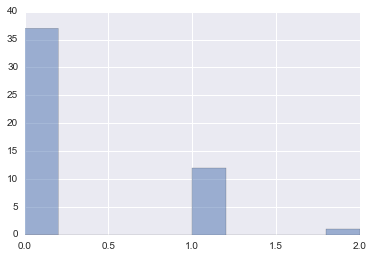

In [9]:
compare_rank(video_score, res, False, True)

Th function $regularized\_vector$ is what Nihar proposed. Suppose $w^*$ is the true value and $\hat{w}$ is the inferred value from our optimization, we want to minimize $||w^* - a \cdot \hat{w} - b||_2^2 $ by finding optimial value of a and b, which will be done through $matching\_func$. And then we introduce a new value $v= a\cdot \hat{w} + b$ as the new weight for the videos. All the error metric evaluation would be made between $v$ and $w^*$

In [ ]:
class Performance_Reconstruction():
    
    
